## Sources
* Covid data: https://systems.jhu.edu/research/public-health/ncov/
* US Testing data: https://covidtracking.com
* World population data: https://www.unfpa.org/sites/default/files/SWOP-Data-2019.xlsx

### Fetching data
Run the `updateData.sh` bash script to update the testing data

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

In [4]:
%matplotlib inline

## By country

In [5]:
worldpop = pd.read_csv('WorldData/WorldPop.csv',index_col='ISO',quoting=1)

In [6]:
worldpop.loc['US']

Name                United States of America
Population (mil)                       329.1
Age 0-14 (pct)                            19
Age 10-24 (pct)                           20
Age 25-64 (pct)                           65
Age 65+ (pct)                             16
Name: US, dtype: object

In [7]:
dataconf = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [8]:
datarec = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [9]:
datadead = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [10]:
# format timestamps
for i in [dataconf,datarec,datadead]:
    oldcols = i.columns.values
    oldcols[4:]=pd.to_datetime(oldcols[4:])
    i.columns=oldcols

Scratch work for calculating the doubling rate $r$ from the day-to-day change $d$:
$$
\begin{gathered}
(1+d)^r = 2 \\
r \ln (1+d) = \ln 2 \\
r = \frac{\ln 2}{\ln(1+d)} \\
1+d = 2^{1/r} \\
d = 2^{1/r}-1
\end{gathered}
$$

In [11]:
def change2double(x):
    # convert daily fraction change to doubling rate
    return np.divide(np.log(2.),np.log(1+x),out=np.full_like(x,np.inf),where=x!=0)

def double2change(x):
    # convert doubling rate to fractional change
    return np.power(2.,1./x)-1

In [12]:
def makeplots(country, iso):
    '''
    Generate plots for a specified country.  Need to specify both the name of the country (as written in the JH database)
    and the two-letter ISO country code.  (Sorry, I couldn't find an easy way to automate the mapping from name to code.)
    '''
    # pull out data
    conf = dataconf[dataconf['Country/Region']==country].drop(['Country/Region','Lat','Long','Province/State'],axis=1).sum()
    rec = datarec[datarec['Country/Region']==country].drop(['Country/Region','Lat','Long','Province/State'],axis=1).sum()
    dead = datadead[datadead['Country/Region']==country].drop(['Country/Region','Lat','Long','Province/State'],axis=1).sum()
    active = conf-rec-dead
    
    pop=worldpop.loc[iso,'Population (mil)']*1e6
    
    #plt.figure(figsize=(12,12))
    
    fig, axes = plt.subplots(2,2,figsize=(12,12),constrained_layout=True)
    fig.suptitle(country)
    conf.plot(ax=axes[0,0])
    rec.plot(ax=axes[0,0])
    dead.plot(ax=axes[0,0])
    active.plot(ax=axes[0,0])
    axes[0,0].set_yscale('log')
    axes[0,0].legend(['Confirmed','Recovered','Dead','Pending'])
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Cases')
    axes[0,0].set_title('Accumulated Cases')
    ax_percap = axes[0,0].secondary_yaxis('right', functions=(lambda x: x/pop, lambda x: x*pop))
    ax_percap.set_ylabel('Cases per capita')

    #plt.subplot(222)
    #conf.plot()
    rec.plot(ax=axes[0,1])
    dead.plot(ax=axes[0,1])
    #active.plot()
    axes[0,1].set_yscale('log')
    axes[0,1].legend(['Recovered','Dead'])
    axes[0,1].set_xlabel('Date')
    axes[0,1].set_ylabel('Cases')
    axes[0,1].set_title('Resolved Cases')
    ax_percap = axes[0,1].secondary_yaxis('right', functions=(lambda x: x/pop, lambda x: x*pop))
    ax_percap.set_ylabel('Cases per capita')
    
    #plt.subplot(223)
    conf.diff().plot(ax=axes[1,0])
    rec.diff().plot(ax=axes[1,0])
    dead.diff().plot(ax=axes[1,0])
    active.diff().plot(ax=axes[1,0])
    #plt.yscale('log')
    axes[1,0].legend(['Confirmed','Recovered','Dead','Pending'])
    axes[1,0].set_xlabel('Date')
    axes[1,0].set_ylabel('Change in cases')
    axes[1,0].set_title('Day-to-day change');
    
    averagingtime = '7D' # string with time units
    
    #plt.subplot(224)
    #conf.pct_change().plot(ax=axes[1,1])
    #dead.pct_change().plot(ax=axes[1,1])
    c_frac = conf.diff()/conf.shift(1)
    d_frac = dead.diff()/dead.shift(1)
    c_frac.plot(ax=axes[1,1],style=':b',alpha=0.5)
    c_frac.rolling(averagingtime).mean().plot(ax=axes[1,1],style='-b')
    d_frac.plot(ax=axes[1,1],style=':r',alpha=0.5)
    d_frac.rolling(averagingtime).mean().plot(ax=axes[1,1],style='-r')
    axes[1,1].set_ylim(0,1)
    ax_doub = axes[1,1].twinx()
    ax_doub.set_ylabel('Doubling time (days)')
    yticks=axes[1,1].get_yticks()
    ax_doub.set_ylim(axes[1,1].get_ylim())
    roundedD = np.array([1.,1.2,1.5,2.,2.5,3.,4.,5.,10.,np.inf])
    ax_doub.set_yticks(double2change(roundedD))
    doublabs = ['{:.1f}'.format(i) for i in roundedD]
    ax_doub.set_yticklabels(doublabs)
    axes[1,1].legend(['Confirmed (daily)','Confirmed (avg)','Dead (daily)','Dead (avg)'])
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Change in cases')
    axes[1,1].set_title('Fractional change from day before');
    
    plt.show()

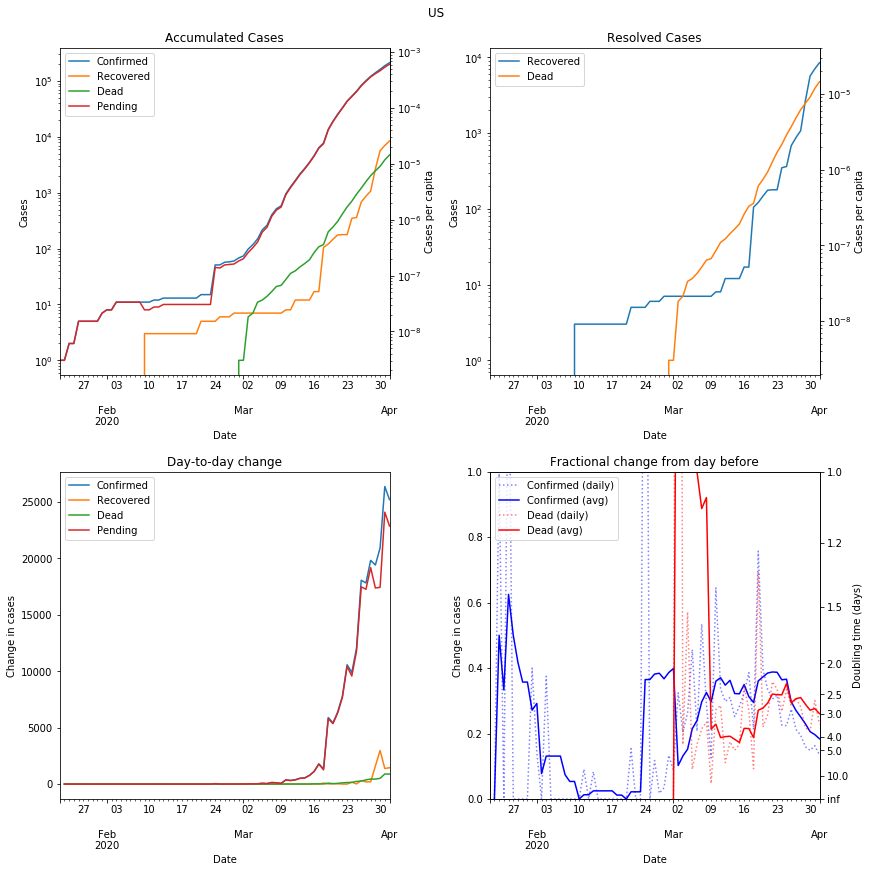

In [13]:
makeplots('US','US')

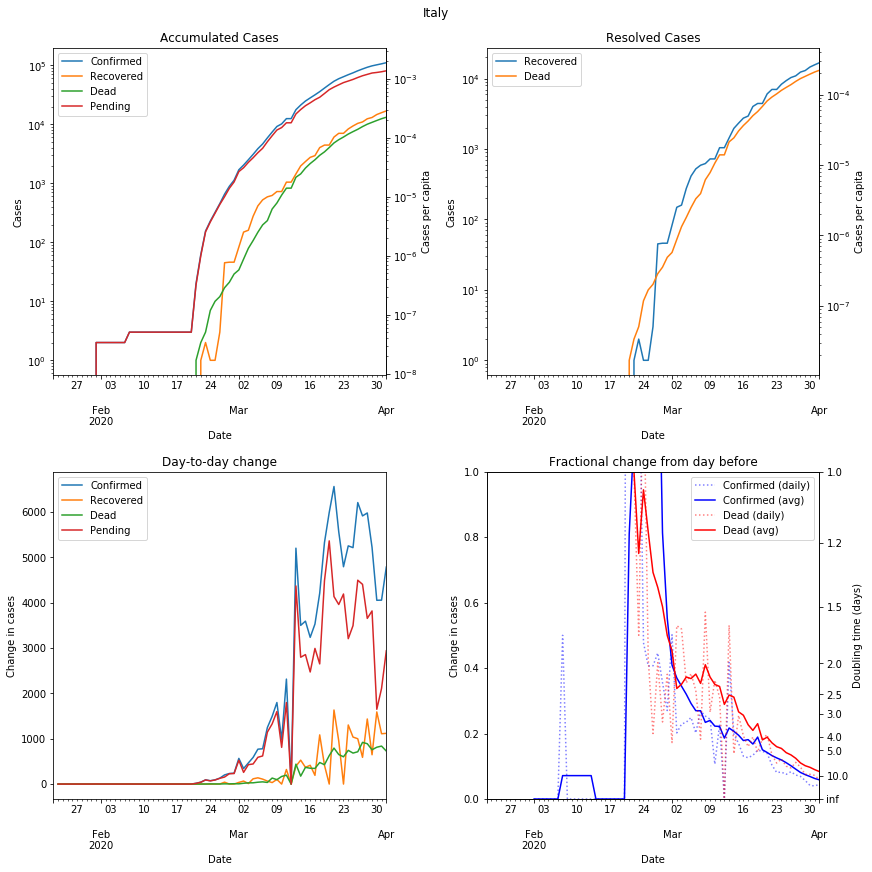

In [14]:
makeplots('Italy','IT')

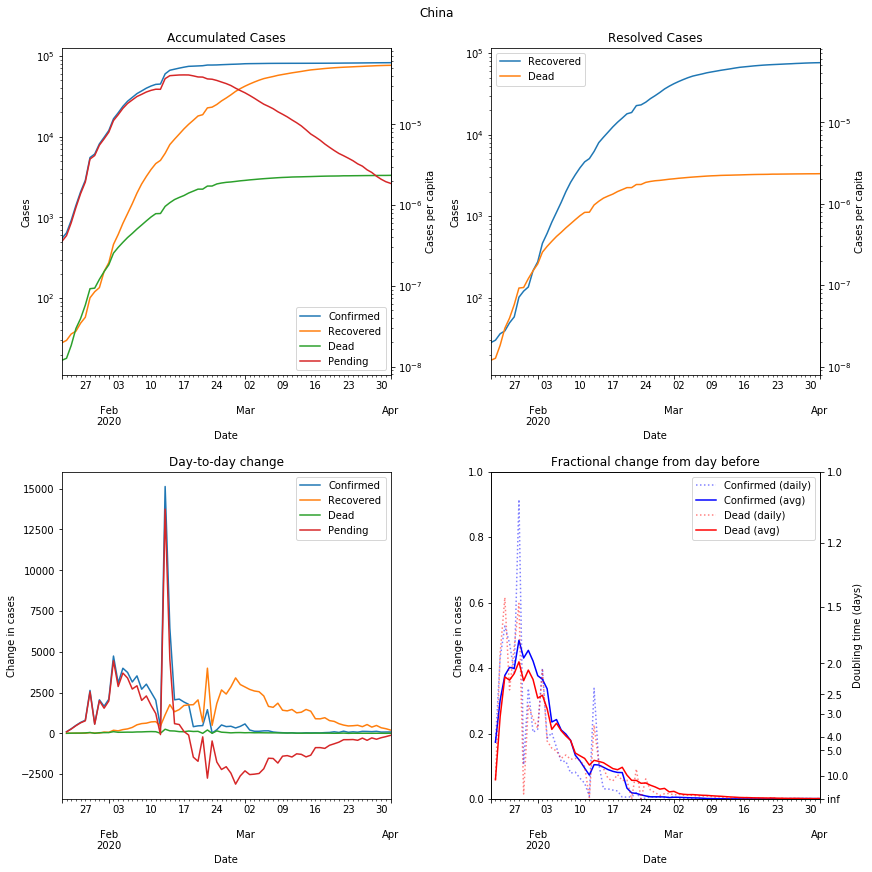

In [15]:
makeplots('China','CN')

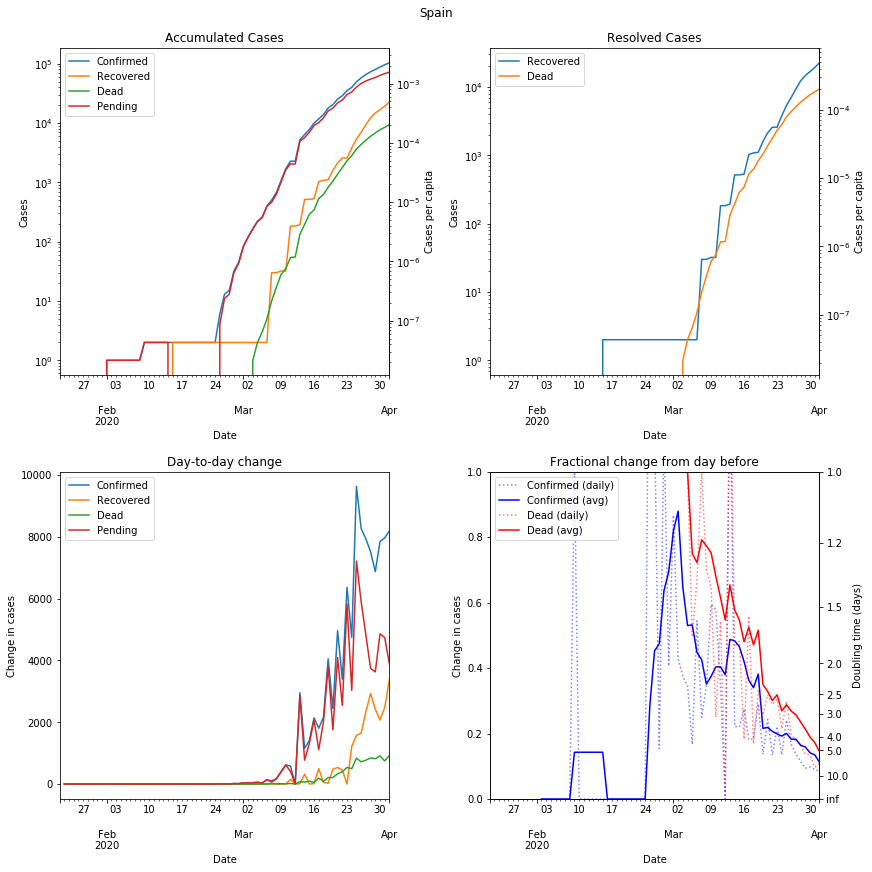

In [16]:
makeplots('Spain','ES')

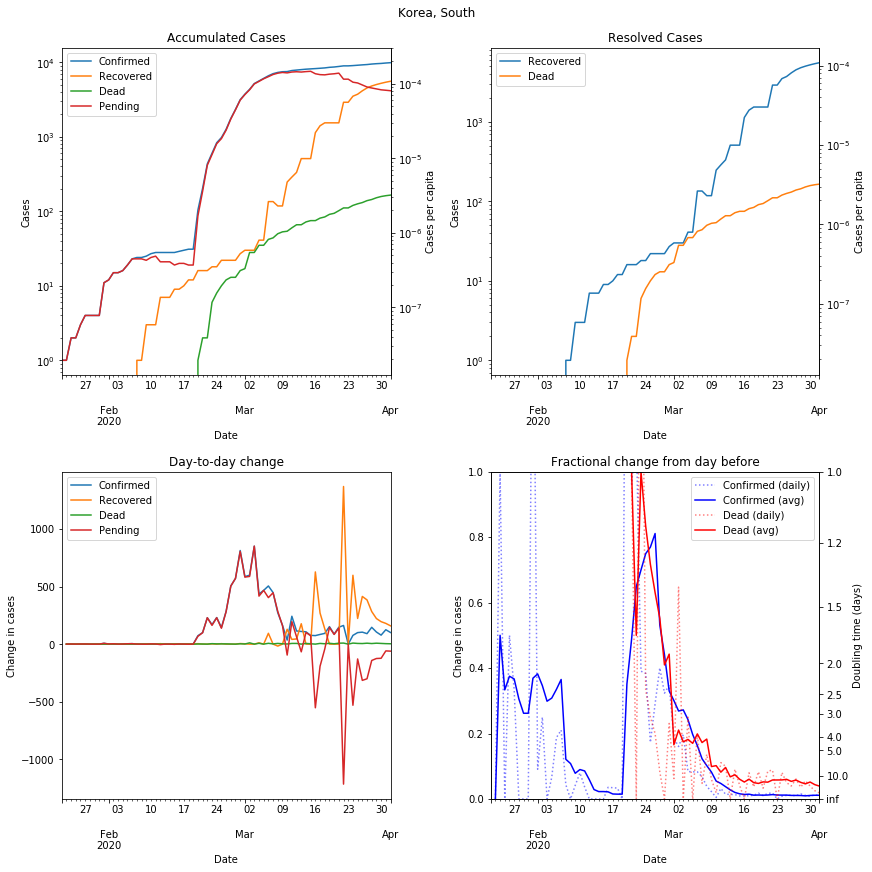

In [17]:
makeplots('Korea, South','KR')

In [18]:
# display the top 10 countries by cases
dataconf.groupby('Country/Region').aggregate('sum').sort_values(dataconf.columns[-1],ascending=False).iloc[:10,2:].index.values

array(['US', 'Italy', 'Spain', 'China', 'Germany', 'France', 'Iran',
       'United Kingdom', 'Switzerland', 'Turkey'], dtype=object)

In [19]:
#manually write the country names in case this changes in the future (alphabetical order)
#list current as of 2020.03.26
namelist=['China', 'France', 'Germany', 'Iran', 'Italy',
       'Korea, South', 'Spain', 'Switzerland', 'US', 'United Kingdom']

In [20]:
#manually write the ISO codes for these so we can pull the population data (same order as above)
isolist = ['CN','FR','DE','IR','IT','KR','ES','CH','US','GB']

In [21]:
# pull out the data from these countries
topconf=dataconf[dataconf['Country/Region'].isin(namelist)].groupby('Country/Region').aggregate('sum').iloc[:10,2:]
toprec= datarec[datarec['Country/Region'].isin(namelist)].groupby('Country/Region').aggregate('sum').iloc[:10,2:]
topdead=datadead[datadead['Country/Region'].isin(namelist)].groupby('Country/Region').aggregate('sum').iloc[:10,2:]


In [22]:
topconf.T.tail()

Country/Region       China  France  Germany   Iran   Italy  Korea, South  \
2020-03-28 00:00:00  81999   38105    57695  35408   92472          9478   
2020-03-29 00:00:00  82122   40708    62095  38309   97689          9583   
2020-03-30 00:00:00  82198   45170    66885  41495  101739          9661   
2020-03-31 00:00:00  82279   52827    71808  44605  105792          9786   
2020-04-01 00:00:00  82361   57749    77872  47593  110574          9887   

Country/Region        Spain  Switzerland      US  United Kingdom  
2020-03-28 00:00:00   73235        14076  121478           17312  
2020-03-29 00:00:00   80110        14829  140886           19780  
2020-03-30 00:00:00   87956        15922  161807           22453  
2020-03-31 00:00:00   95923        16605  188172           25481  
2020-04-01 00:00:00  104118        17768  213372           29865

In [23]:
# reindex
for i in [topconf,toprec,topdead]:
    i['iso']=isolist
    i.reset_index(inplace=True)
    i.set_index('iso',inplace=True)
    i.drop('Country/Region',axis=1,inplace=True)

In [24]:
topactive=topconf-toprec-topdead

In [25]:
# check that we got the mapping right between name and iso code
#topconf['Country/Region']

<Figure size 432x288 with 0 Axes>

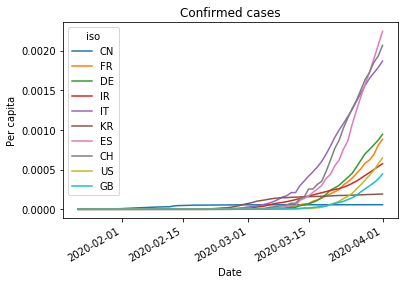

In [26]:
plt.figure()
(topconf.T/worldpop.loc[isolist,'Population (mil)'].values/1e6).plot()
#plt.yscale('log')
plt.ylabel('Per capita')
plt.xlabel('Date')
plt.title('Confirmed cases');

<Figure size 432x288 with 0 Axes>

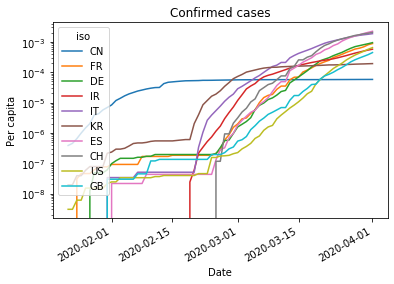

In [27]:
plt.figure()
(topconf.T/worldpop.loc[isolist,'Population (mil)'].values/1e6).plot()
plt.yscale('log')
plt.ylabel('Per capita')
plt.xlabel('Date')
plt.title('Confirmed cases');

<Figure size 432x288 with 0 Axes>

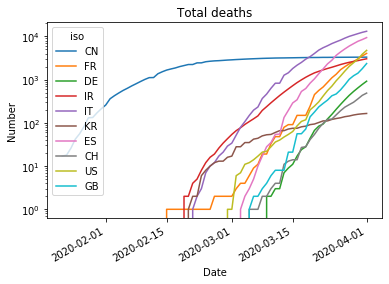

In [28]:
plt.figure()
(topdead.T).plot()
plt.yscale('log')
plt.ylabel('Number')
plt.xlabel('Date')
plt.title('Total deaths');

<Figure size 432x288 with 0 Axes>

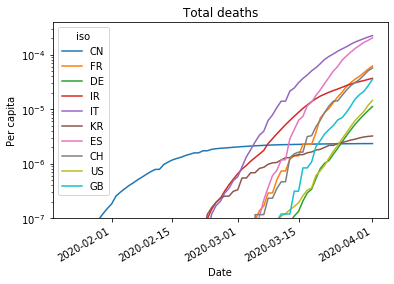

In [29]:
plt.figure()
(topdead.T/worldpop.loc[isolist,'Population (mil)'].values/1e6).plot()
plt.yscale('log')
plt.ylabel('Per capita')
plt.xlabel('Date')
plt.ylim((1e-7,None))
plt.title('Total deaths');

<Figure size 432x288 with 0 Axes>

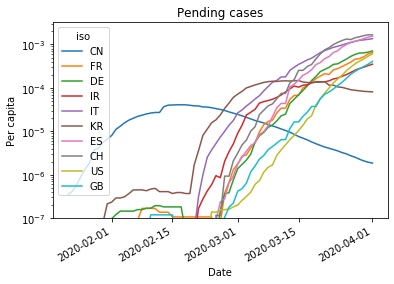

In [30]:
plt.figure()
(topactive.T/worldpop.loc[isolist,'Population (mil)'].values/1e6).plot()
plt.yscale('log')
plt.ylabel('Per capita')
plt.xlabel('Date')
plt.ylim((1e-7,None))
plt.title('Pending cases');

# US states

In [31]:
stateconf=dataconf[dataconf['Country/Region']=='US'].drop(['Country/Region','Lat','Long'],axis=1).set_index('Province/State')
staterec = datarec[datarec['Country/Region']=='US'].drop(['Country/Region','Lat','Long'],axis=1).set_index('Province/State')
statedead = datadead[datadead['Country/Region']=='US'].drop(['Country/Region','Lat','Long'],axis=1).set_index('Province/State')
stateactive = stateconf-staterec-statedead

In [32]:
stateconf.sort_values(stateconf.columns[-1],ascending=False).iloc[:,-1].head(10)

Province/State
NaN    213372
Name: 2020-04-01 00:00:00, dtype: int64

In [33]:
stateconf.loc[['Pennsylvania','Washington','New Jersey','Louisiana','California','New York'],:].T.tail(10)

KeyError: "None of [Index(['Pennsylvania', 'Washington', 'New Jersey', 'Louisiana', 'California',\n       'New York'],\n      dtype='object', name='Province/State')] are in the [index]"

In [ ]:
stateconf.loc[['Pennsylvania','Washington','New Jersey','Louisiana','California','New York'],:].T.tail(10).plot()
plt.title('Total cases by state')
plt.yscale('log')

In [ ]:
conf = stateconf.loc[['Pennsylvania','Washington','New Jersey','Louisiana','California','New York'],:].T

fig, ax = plt.subplots(1,1)
(conf.diff()/conf.shift(1)).plot(ax=ax)
#(dead.diff()/dead.shift(1)).plot(ax=ax)
ax.set_ylim(0,1)
ax_doub = ax.twinx()
ax_doub.set_ylabel('Doubling time (days)')
roundedD = np.array([1.,1.2,1.5,2.,2.5,3.,4.,5.,10.,np.inf])
ax_doub.set_yticks(double2change(roundedD))
doublabs = ['{:.1f}'.format(i) for i in roundedD]
ax_doub.set_yticklabels(doublabs)
#ax.legend(['Confirmed','Dead'])
ax.set_xlabel('Date')
ax.set_ylabel('Change in cases')
ax.set_title('Fractional change in cases from day before')
plt.show()

In [ ]:
dead = statedead.loc[['Pennsylvania','Washington','New Jersey','Louisiana','California','New York'],:].T

fig, ax = plt.subplots(1,1)
#(conf.diff()/conf.shift(1)).plot(ax=ax)
(dead.diff()/dead.shift(1)).plot(ax=ax)
ax.set_ylim(0,1)
ax_doub = ax.twinx()
ax_doub.set_ylabel('Doubling time (days)')
roundedD = np.array([1.,1.2,1.5,2.,2.5,3.,4.,5.,10.,np.inf])
ax_doub.set_yticks(double2change(roundedD))
doublabs = ['{:.1f}'.format(i) for i in roundedD]
ax_doub.set_yticklabels(doublabs)
#ax.legend(['Confirmed','Dead'])
ax.set_xlabel('Date')
ax.set_ylabel('Change in cases')
ax.set_title('Fractional change in deaths from day before')
plt.show()